In [12]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pyunpack
!pip install patool

from pyunpack import Archive
Archive('/content/drive/MyDrive/DATASETMIX.zip').extractall('/content/')

data_dir = "/content/rice_leaf_diseases"

# Pilih Model from [resnet34, resnet101]
model_name = "resnet34"

# Number of classes in the dataset
num_classes = 5

# Batch size for training (change depending on how much memory you have)
batch_size = 8
feature_extract = True



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double(
            ) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(
    model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names = image_datasets['train'].classes

Initializing Datasets and Dataloaders...


In [17]:
model_ft = model_ft.to(device)


params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

optimizer_ft = optim.RMSprop(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 fc.weight
	 fc.bias


In [18]:
criterion = nn.CrossEntropyLoss()

# Pelatihan Model
model_conv, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft,
                             num_epochs=10, is_inception=(model_name == "inception"))


Epoch 0/9
----------
train Loss: 2.8843 Acc: 0.4750
val Loss: 2.3499 Acc: 0.5750

Epoch 1/9
----------
train Loss: 1.0026 Acc: 0.7875
val Loss: 3.5147 Acc: 0.6750

Epoch 2/9
----------
train Loss: 1.1252 Acc: 0.7625
val Loss: 2.5916 Acc: 0.6000

Epoch 3/9
----------
train Loss: 1.3129 Acc: 0.7250
val Loss: 3.3863 Acc: 0.5750

Epoch 4/9
----------
train Loss: 1.5455 Acc: 0.7375
val Loss: 3.1016 Acc: 0.5750

Epoch 5/9
----------
train Loss: 0.6247 Acc: 0.8125
val Loss: 2.3288 Acc: 0.6000

Epoch 6/9
----------
train Loss: 1.0424 Acc: 0.7938
val Loss: 3.1166 Acc: 0.6250

Epoch 7/9
----------
train Loss: 0.6495 Acc: 0.8438
val Loss: 2.2052 Acc: 0.6750

Epoch 8/9
----------
train Loss: 0.5151 Acc: 0.8750
val Loss: 2.5095 Acc: 0.5750

Epoch 9/9
----------
train Loss: 0.6140 Acc: 0.8313
val Loss: 2.7891 Acc: 0.6000

Training complete in 1m 23s
Best val Acc: 0.675000


In [9]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print('\nConfusion Matrix\n')
print(confusion_matrix)


Confusion Matrix

tensor([[6., 0., 2., 0., 0.],
        [5., 0., 3., 0., 0.],
        [2., 1., 5., 0., 0.],
        [0., 0., 0., 7., 1.],
        [0., 0., 0., 0., 8.]])


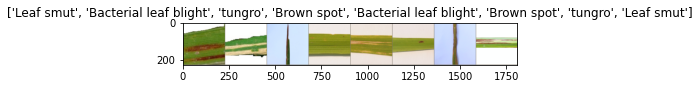

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders_dict['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

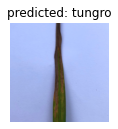

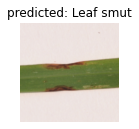

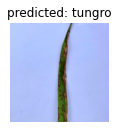

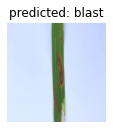

In [11]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_conv)